# Quantum Key Distribution

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
%matplotlib inline

# Without interception

## Step-1 Person 1 (p1) generates its message bits

In [2]:
np.random.seed(seed=0) #start value for random bits
n = 50

p1_bits = randint(2, size=n) # initializes p1's message of random bits of random range (0-50)
print(p1_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1]


## Step-2 Encoding of each bit by p1 in random qubit basis (i.e, X or Z-basis)

0 means Z-basis and 1 means X-basis

In [3]:
p1_bases = randint(2,size=n) # array to tell which bits in which bases
print(p1_bases) 

[0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 1 0 1 1 0 0 1 0 0 1 1 0]


In [4]:
# function to create a list of QuantumCircuits, each circuit to represent a single qubit in p1 message

def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0) #flip the bit
                
        else: # prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0) #hadamard gate to create superposition 
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [5]:
message = encode_message(p1_bits,p1_bases)

In [6]:
print(p1_bits[0],p1_bases[0])

0 0


printing 5 circuits to show the qubit states using Qiskit :

In [7]:
for x in range(0,5):
    print("circuit for bit :", x,"\n")
    print(message[x].draw()) 

circuit for bit : 0 

      ░ 
q_0: ─░─
      ░ 
c_0: ═══
        
circuit for bit : 1 

     ┌───┐┌───┐ ░ 
q_0: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c_0: ═════════════
                  
circuit for bit : 2 

     ┌───┐┌───┐ ░ 
q_0: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c_0: ═════════════
                  
circuit for bit : 3 

     ┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c_0: ════════
             
circuit for bit : 4 

     ┌───┐┌───┐ ░ 
q_0: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c_0: ═════════════
                  


## Step-3 Person 2 (p2) creation of bases and other measurements

In [8]:
p2_bases = randint(2, size=n)
print(p2_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1]


In [9]:
# measure (deocde) the p1's message according to p2's bases

def measure_message(message, bases):
    
    backend = Aer.get_backend('qasm_simulator') #to measure a qubit, qasm simulator is needed
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
            
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
            
        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
        
    return measurements

In [10]:
p2_results = measure_message(message, p2_bases)

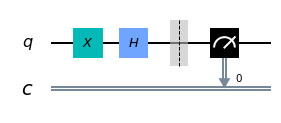

In [11]:
%matplotlib inline
message[1].draw(output='mpl')

In [12]:
print(p2_results) # p2's decoded message 

[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]


## Step-4 Sharing of bases by p1 and p2

In [13]:
# function to check which bits match between p1_bits (original message) and p2_results (decoded_message)

def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

In [14]:
## Step 4
p1_key = remove_garbage(p1_bases,p2_bases,p1_bits)

print(p1_key) #secret key of p1

p2_key = remove_garbage(p1_bases, p2_bases, p2_results)

print(p2_key) #secret key of p2

[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]
[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]


## Step-5 comparison of p1's and p2's key's generated by decoding using their shared qubit bases

In [15]:
# function to compare a random selection of bits in their keys to make sure the protocol worked correctly:

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits)) # to set bit to be always less than list range
        
        sample.append(bits.pop(i)) # to remove element of the list at index 'i' and append in sample
    return sample

In [16]:
## Step 5

sample_size = 15
bit_selection = randint(n, size=sample_size)

p2_sample = sample_bits(p2_key, bit_selection)
print("  p2_sample = " + str(p2_sample))

p1_sample = sample_bits(p1_key, bit_selection)
print("p1_sample = "+ str(p1_sample))

  p2_sample = [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
p1_sample = [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]


In [17]:
# If the protocol has worked correctly without interference, their samples should match:

if (p2_sample==p1_sample): 
    print("samples matched\n\n") # means they now share a secret key they can use to encrypt their messages
else:
    print("not matched")

samples matched




# With interception

## Let’s now see how p1 and p2 can tell if p3(person 3) has been trying to listen in on their quantum message. 

We repeat the same steps as without interference, but before p2 receives his qubits, p3 will try to extract some info from them. <br><br>
random seed is different tahn before so as to make results not dependent on above process (without interception)

In [18]:
np.random.seed(seed=3)

### Step-1 p1 generates his set of random bits :

In [19]:
np.random.seed(seed=3)
## Step 1
p1_new_bits = randint(2, size=n)
print(p1_new_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1]


### Step-2  p1 encodes these in the 𝑍 and 𝑋-bases at random, and sends these to p2 through p3's quantum channel:

In [20]:
## Step 2

p1_new_bases = randint(2, size=n)
message_new = encode_message(p1_new_bits, p1_new_bases)
print(p1_new_bases)

[1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1
 1 0 1 0 0 0 0 0 1 1 0 1 1]


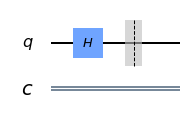

In [21]:
message_new[0].draw(output='mpl') 

In this case, the first qubit in p1's message is in the state |+⟩ (state in x-basis)

### Step-3 finding interception

In [22]:
p3_new_bases = randint(2, size=n)
print("p3-new-bases :",p3_new_bases,"\n")
intercepted_message = measure_message(message_new, p3_new_bases)
print("intercepted message by p3 :", intercepted_message)

p3-new-bases : [1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0] 

intercepted message by p3 : [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]


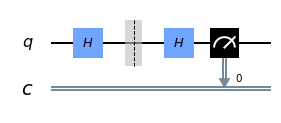

In [23]:
message_new[0].draw(output='mpl')

We can see the case of qubit 0 above, p3's random choice of basis is not the same as p1's, and this will change the qubit state from |+⟩, to a random state in the 𝑍-basis, with 50% probability of |0⟩ or |1⟩:

### Step-4 

p3 then passes on the qubits to p2, who measures them at random. In this case, p2 chose (by chance) to measure in the same basis p1 prepared the qubit in. Without interception, p2 would be guaranteed to measure 0, but because p3 tried to read the message he now has a 50% chance of measuring 1 instead.

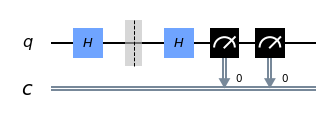

In [24]:
## Step 4

p2_new_bases = randint(2, size=n)
p2_new_results = measure_message(message_new, p2_new_bases)
message_new[0].draw(output='mpl')

### Step-5 

In [25]:
# p2 and p1 reveal their basis choices, and discard the useless bits:

p2_new_key = remove_garbage(p1_new_bases, p2_new_bases, p2_new_results)
p1_new_key = remove_garbage(p1_new_bases, p2_new_bases, p1_new_bits)

### Step-6
p2 and p1 compare the same random selection of their keys to see if the qubits were intercepted:

In [26]:
## Step 6

sample_size = 15

bit_selection = randint(n, size=sample_size)

p2_new_sample = sample_bits(p2_new_key , bit_selection)
print("  p2_new_sample = " + str(p2_new_sample))

p1_new_sample = sample_bits(p1_new_key, bit_selection)
print("p1_new_sample = "+ str(p1_new_sample))

  p2_new_sample = [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]
p1_new_sample = [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]


In [27]:
# If the protocol has worked correctly without interference, their samples should match:

if (p2_new_sample==p1_new_sample): 
    print("samples matched") # means they now share a secret key they can use to encrypt their messages
else:
    print("not matched") # means there has been an inteception by p3

not matched


>p2's key and p1's key do not match. 

We know this because p3 tried to read the message between steps 3 and 4, and changed the qubits' states. 

p1 and p2 know, this could be due to noise in the channel, but due to this they must throw away all their results and try again

> therefore p3's interception attempt has failed.